# **Treinamendo dos modelos**

#### **1. Importando Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from joblib import dump

#### **2. Carregando e preparando dados**

In [2]:
# Carregando os dados
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
caminho_thrusted = os.path.join(BASE_DIR, 'dados', 'thrusted', 'imoveis_sem_outliers.csv')
df = pd.read_csv(f"{caminho_thrusted}")

#### **3. Pré-processando os dados**

In [3]:
X = df.drop("preco", axis=1)
y = df["preco"]

le_bairro = LabelEncoder()
X["bairro"] = le_bairro.fit_transform(X["bairro"])
colunas_remover = ['school', 'supermarket', 'restaurant']
X = X.drop(columns=colunas_remover)

#### **4. Função de avaliação dos modelos por crossfit validation usando R², MAE, RMSE**

In [4]:
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
}

def avaliar_modelo_cv(modelo, X, y, cv=10):
    resultados = cross_validate(modelo, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    media_r2 = np.mean(resultados['test_r2'])
    media_mae = np.mean(resultados['test_mae'])
    media_rmse = np.mean(resultados['test_rmse'])
    
    print(f'\n🔍 Avaliando {modelo.__class__.__name__}')
    print(f'R² médio:   {media_r2:.4f}')
    print(f'MAE médio:  {media_mae:.2f}')
    print(f'RMSE médio: {media_rmse:.2f}')
    
    return {
        'r2': media_r2,
        'mae': media_mae,
        'rmse': media_rmse
    }

#### **5. Modelos a serem avaliados**

In [5]:
modelos = {   
    "Random Forest": RandomForestRegressor(random_state=42),
    "LightGBM":LGBMRegressor(
        random_state=42,
        verbose=-1 # silencia warnings
        ),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

#### **6. Avaliação dos modelos**

In [6]:
resultados_modelos_cv = {}

for nome, modelo in modelos.items():
    resultados = avaliar_modelo_cv(modelo, X, y)
    resultados_modelos_cv[nome] = resultados


🔍 Avaliando RandomForestRegressor
R² médio:   0.5375
MAE médio:  61486.88
RMSE médio: 83283.31

🔍 Avaliando LGBMRegressor
R² médio:   0.5156
MAE médio:  63690.31
RMSE médio: 85508.54

🔍 Avaliando CatBoostRegressor
R² médio:   0.5288
MAE médio:  61177.00
RMSE médio: 84084.00


#### **7. Treinamendo do modelo**

In [7]:
def treinar_modelo_otimizado(X, y, param_grid=None, test_size=0.2, random_state=42,
                              cv=5, scoring='r2', caminho_modelo='modelo_otimizado.joblib'):
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

    # 1. Dividir os dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # 2. Otimização com GridSearchCV
    rf = RandomForestRegressor(random_state=random_state)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # 3. Melhor modelo e predições
    melhor_modelo = grid_search.best_estimator_
    y_pred = melhor_modelo.predict(X_test)

    # 4. Avaliação
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Resultados
    print("Melhores hiperparâmetros:")
    print(grid_search.best_params_)

    print("\nMelhor R² obtido (validação cruzada):")
    print(f"{grid_search.best_score_:.4f}")

    print("\n📊 Avaliação do modelo em dados nunca vistos:")
    print(f"R²:   {r2:.4f}")
    print(f"MAE:  R$ {mae:,.2f}")
    print(f"RMSE: R$ {rmse:,.2f}")

    # 5. Exportar modelo treinado
    dump(melhor_modelo, caminho_modelo)
    print(f"\n✅ Modelo exportado com sucesso para: {caminho_modelo}")

    return melhor_modelo, grid_search.best_params_, r2, mae, rmse

caminho_modelos=os.path.join(BASE_DIR, 'modelos')
modelo='random_forest_sem_outliers.joblib'
rf, _, _, _, _ = treinar_modelo_otimizado(X, y, caminho_modelo=f'{caminho_modelos}/{modelo}')

Melhores hiperparâmetros:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

Melhor R² obtido (validação cruzada):
0.6078

📊 Avaliação do modelo em dados nunca vistos:
R²:   0.6226
MAE:  R$ 64,026.02
RMSE: R$ 83,463.36

✅ Modelo exportado com sucesso para: /Users/Homailson/Documents/WebScrapZapImoveis/modelos/random_forest_sem_outliers.joblib


#### **8. Exemplo de Predição**

In [8]:
# ----------------------------
# Dados do imóvel para predição
dados_imovel = {
    "bairro": ["Vila Passos"],
    "area": [600],
    "quartos": [3],
    "banheiros": [2],
    "vagas": [2],
    "hospital": [1],
    "gas_station": [1],
    "pharmacy": [1]
}

df_imovel = pd.DataFrame(dados_imovel)

# ----------------------------
# Verificar se o bairro existe no encoder
bairro = df_imovel["bairro"].iloc[0]
if bairro not in le_bairro.classes_:
    print(f"❌ Bairro '{bairro}' não reconhecido pelo modelo treinado.")
else:
    # Transformar o bairro com LabelEncoder
    df_imovel["bairro"] = le_bairro.transform(df_imovel["bairro"])

    # Garantir ordem das colunas igual ao treino
    colunas_modelo = ['bairro', 'area', 'quartos', 'banheiros', 'vagas',
                      'hospital', 'gas_station', 'pharmacy']
    df_imovel = df_imovel[colunas_modelo]

    # Fazer predição
    preco_predito = rf.predict(df_imovel)
    print(f"✅ Preço previsto para o imóvel: R$ {preco_predito[0]:,.2f}")

✅ Preço previsto para o imóvel: R$ 399,662.28


       Feature  Importância
1         area     0.334476
3    banheiros     0.232268
2      quartos     0.193386
0       bairro     0.138970
4        vagas     0.060272
6  gas_station     0.028487
5     hospital     0.006702
7     pharmacy     0.005440


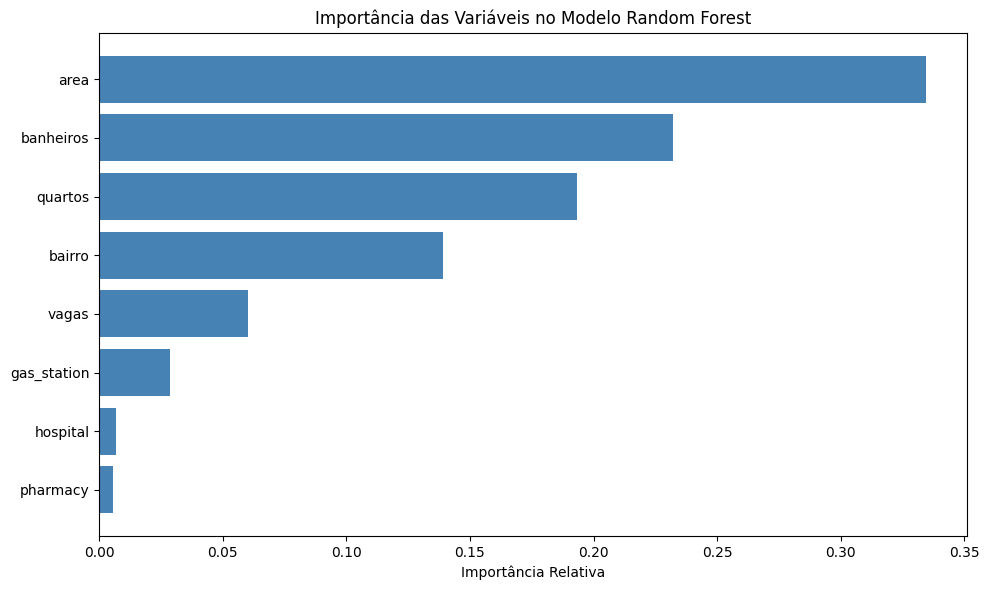

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Pegando os nomes das colunas
feature_names = X.columns

# Importâncias calculadas pelo modelo
importancias = rf.feature_importances_

# Criar um DataFrame para melhor visualização
df_importancia = pd.DataFrame({
    'Feature': feature_names,
    'Importância': importancias
}).sort_values(by='Importância', ascending=False)

# Mostrar a tabela ordenada
print(df_importancia)

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Feature'], df_importancia['Importância'], color='steelblue')
plt.gca().invert_yaxis()  # Inverter y para maior em cima
plt.title('Importância das Variáveis no Modelo Random Forest')
plt.xlabel('Importância Relativa')
plt.tight_layout()
plt.show()